# Mark rooftops with u-net

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/M_DV_V2022

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/MyDrive/M_DV_V2022'
/content/gdrive/MyDrive/M_DV_V2022


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, Flatten, \
                         UpSampling2D, Conv2DTranspose, MaxPooling2D, \
                         Dropout, Concatenate, BatchNormalization, Activation, \
                         concatenate
from tensorflow.keras.optimizers import Adam

import keras.backend as K

### Load data

In [6]:
X = np.load("data/u_net_roofs/X_data.npy")
y = np.load("data/u_net_roofs/y_data.npy") 

#X = (X - X.mean(axis=0)) / X.std(axis=0)

# Adds a new dimension of layer too have two class problem.
yy = np.append(y, np.zeros((50, 64, 64,1)), axis=3)
yy[yy >= 0.001] = 1
yy1 = yy.copy()
yy1[:,:,:,0] = 0
for i in range(50):
  values = yy[i,:,:,0]
  for r in range(64):
    for c in range(64):
      value = yy[i,r,c,0]
      yy1[i,r,c,int(value)] = 1


print(y.shape)
print(yy1.shape)

(50, 64, 64, 1)
(50, 64, 64, 2)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    yy1, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [8]:
X.shape

(50, 64, 64, 176)

### Make u net

In [9]:
"""
Version of U-Net with dropout and size preservation (padding= 'same')
""" 
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True, n_classes = 2):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model



def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


### Show data - 5 random images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 7 12 11 35 33]


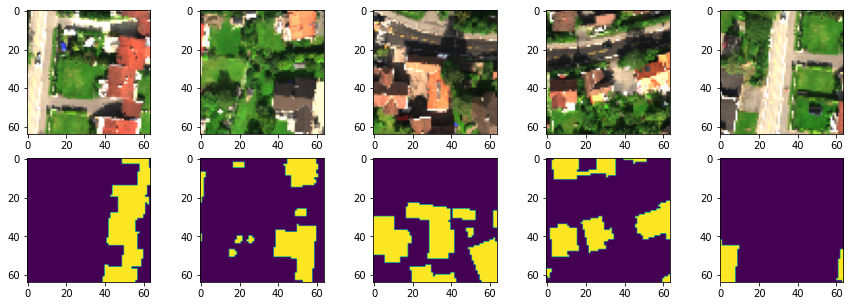

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize = (15,5))

indx = np.random.randint(0,high=X_train.shape[0],size=5)
print(indx)
for i in range(5):
    ax[0,i].imshow(np.dstack((X_train[indx[i]][:,:,76],
                              X_train[indx[i]][:,:,46],
                              X_train[indx[i]][:,:,21])))
    ax[1,i].imshow(y_train[indx[i]][:,:,1])
plt.show()

### Set up u net

In [21]:
input_img = Input(shape=(64,64,176))
uu = get_unet(input_img, n_classes=2)

uu.compile(optimizer=Adam(learning_rate=0.01),
                 loss='binary_crossentropy',
                 metrics=['accuracy', get_f1])

In [22]:
h = uu.fit(X_train, y_train, 
           validation_data=(X_test,y_test), 
           batch_size=10,
           epochs=500)

Epoch 1/500
4/4 [==============================] - 4s 330ms/step - loss: 0.6379 - accuracy: 0.6141 - get_f1: 0.6141 - val_loss: 386361.6875 - val_accuracy: 0.2661 - val_get_f1: 0.2661
Epoch 2/500
4/4 [==============================] - 0s 106ms/step - loss: 0.4746 - accuracy: 0.7698 - get_f1: 0.7698 - val_loss: 12858406.0000 - val_accuracy: 0.2122 - val_get_f1: 0.2122
Epoch 3/500
4/4 [==============================] - 0s 101ms/step - loss: 0.4176 - accuracy: 0.8137 - get_f1: 0.8137 - val_loss: 22404964.0000 - val_accuracy: 0.2237 - val_get_f1: 0.2237
Epoch 4/500
4/4 [==============================] - 0s 99ms/step - loss: 0.3719 - accuracy: 0.8581 - get_f1: 0.8581 - val_loss: 723727.8750 - val_accuracy: 0.2856 - val_get_f1: 0.2856
Epoch 5/500
4/4 [==============================] - 0s 101ms/step - loss: 0.3246 - accuracy: 0.8807 - get_f1: 0.8807 - val_loss: 59140.9688 - val_accuracy: 0.2205 - val_get_f1: 0.2205
Epoch 6/500
4/4 [==============================] - 0s 107ms/step - loss: 0.286

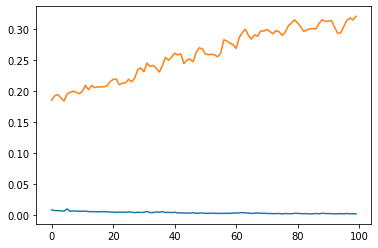

In [24]:
plt.plot(h.history['loss'][400:])
plt.plot(h.history['val_loss'][400:])

### Test prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


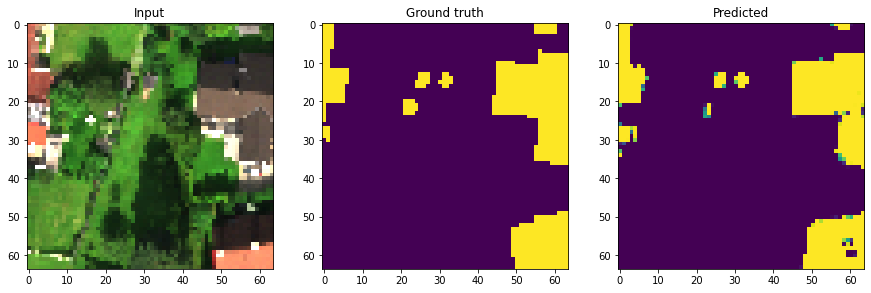

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


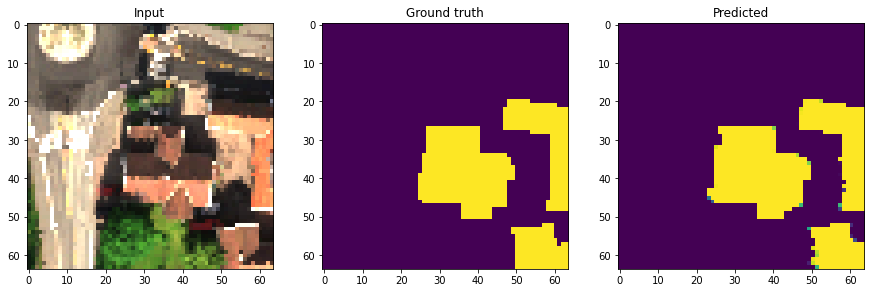

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


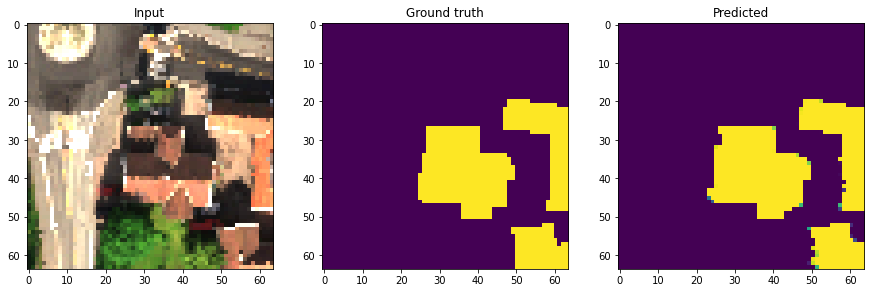

In [25]:
for _ in range(3):
  x = np.random.randint(X_test.shape[0])
  fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3, figsize = (15,15))
  ax1.imshow(np.dstack((X_test[x:x+1][0][:,:,76],
                        X_test[x:x+1][0][:,:,46],
                        X_test[x:x+1][0][:,:,21])))
  ax1.set_title("Input")
  ax2.imshow(y_test[x:x+1][0][:,:,1])
  ax2.set_title("Ground truth")
  pred = uu.predict(X_test[x:x+1])[0][:,:,1]
  ax3.imshow(pred)
  ax3.set_title("Predicted")
  plt.show()

## Test on unseen data

In [27]:
X_unseen = np.load("data/u_net_roofs/X_data_unseen.npy")
y_unseen = np.load("data/u_net_roofs/y_data_unseen.npy")

# Adds a new dimension of layer too have two class problem.
yy = np.append(y_unseen, np.zeros((50, 64, 64,1)), axis=3)
yy[yy >= 0.001] = 1
yy1 = yy.copy()
yy1[:,:,:,0] = 0
for i in range(50):
  values = yy[i,:,:,0]
  for r in range(64):
    for c in range(64):
      value = yy[i,r,c,0]
      yy1[i,r,c,int(value)] = 1


print(y.shape)
print(yy1.shape)

(50, 64, 64, 1)
(50, 64, 64, 2)


In [28]:
pred = uu.predict(X_unseen)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


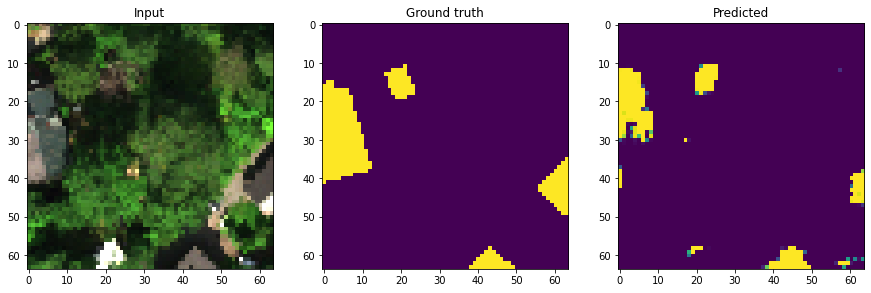

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Acc score: 0.77587890625
f1 score: 0.12237093690248564


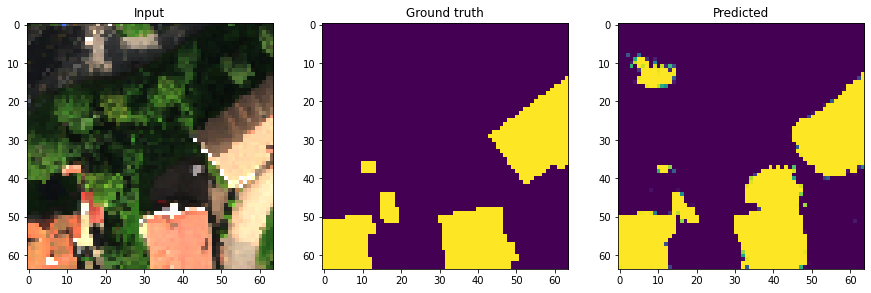

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Acc score: 0.642333984375
f1 score: 0.1407624633431085


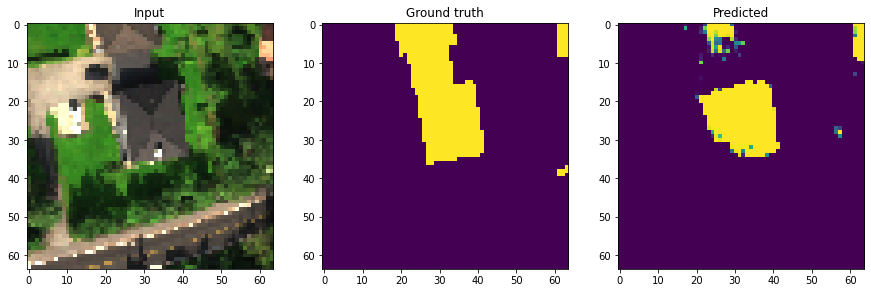

Acc score: 0.7705078125
f1 score: 0.09788867562380038


In [30]:
for _ in range(3):
  x = np.random.randint(pred.shape[0])
  fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3, figsize = (15,15))
  ax1.imshow(np.dstack((X_unseen[x:x+1][0][:,:,76],
                        X_unseen[x:x+1][0][:,:,46],
                        X_unseen[x:x+1][0][:,:,21])))
  ax1.set_title("Input")
  ax2.imshow(yy1[x:x+1][0][:,:,1])
  ax2.set_title("Ground truth")
  ax3.imshow(pred[x:x+1][0][:,:,1])
  ax3.set_title("Predicted")
  plt.show()

  # Metrics  w threshold:
  pred[x:x+1,:,:,0][pred[x:x+1,:,:,0] > .5] = 1
  pred[x:x+1,:,:,0][pred[x:x+1,:,:,0] <= .5] = 0
  pred[x:x+1,:,:,1][pred[x:x+1,:,:,1] > .5] = 1
  pred[x:x+1,:,:,1][pred[x:x+1,:,:,1] <= .5] = 0

  print(f"Acc score: {accuracy_score(y[x:x+1][0].flatten(),\
                                     pred[x:x+1][0].argmax(axis=2).flatten())}")
  print(f"f1 score: {f1_score(y[x:x+1][0].flatten(),\
                                     pred[x:x+1][0].argmax(axis=2).flatten())}")
  
  

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


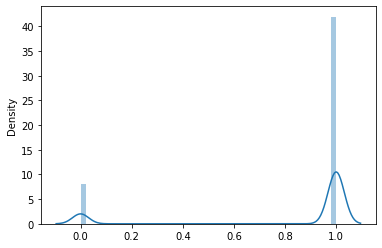

In [ ]:
sns.distplot(pred[:,:,:,0])

In [ ]:
!git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/stianteien/M_DV_V2022
   032c1eb..e07fd6c  master     -> origin/master
Updating 032c1eb..e07fd6c
Fast-forward
 roofs_w_unet/roof_u-net.ipynb | 844 ++++++++++++++++++++++++++----------------
 1 file changed, 526 insertions(+), 318 deletions(-)
